# 🛠️ Structural Problems

| Problem Name         | Problem Description                                                                 | Example                                                                 |
|----------------------|-------------------------------------------------------------------------------------|-------------------------------------------------------------------------|
| Concatenated Tokens  | The key glues multiple concepts together without clear separation, making it hard to interpret. | `attestationstatementtelehealth` → could mean *attestation statement telehealth*, but unclear without splitting. |
| Missing Field Title  | The key does not contain a descriptive field title, making its meaning incomplete or ambiguous. | *(No title present at all — cannot infer context.)*                     |
| Invalid Tokens       | The key contains non-standard or corrupted tokens that do not map to meaningful concepts. | `@@field!!` → not interpretable.                                        |

---

# 💡 Semantic Problems

| Problem Name                 | Problem Description                                                           | Example                                                                 |
|-------------------------------|-------------------------------------------------------------------------------|-------------------------------------------------------------------------|
| Generic Field Key / Missing Context | The key doesn’t specify what should go into the field; the concept is too broad or abstract. | `summary` → summary of what? <br>`issues` → could mean many different things. |
| Hidden Agent (Lack of Role Context) | The key doesn’t indicate *who* the field refers to.                        | `response` → response by client, provider, or supervisor?               |
| Lack of Temporal Context      | The key refers to change or status without specifying a timeframe.            | `progress` → progress since when?                                       |
| Misaligned Concepts           | The field key doesn’t accurately represent the semantic intent of the field title. | `field_key`: `present` <br>`field_title`: `Interventions provided` → Missing context about “details of contact.” |


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Field-Key-Analysis'

/content/drive/MyDrive/Field-Key-Analysis


In [3]:
%pwd

'/content/drive/MyDrive/Field-Key-Analysis'

## Setup

### Install Packages

In [4]:
from __future__ import annotations

import logging
import os
import pickle
import re
import sys
from pathlib import Path
from pprint import pformat
from typing import Callable, Optional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sentence_transformers import SentenceTransformer
!pip install nbstripout
import nbstripout
!pip install wordfreq
from wordfreq import zipf_frequency
from nli_apply import add_axis_columns_batched
from nli_helpers import nli_probe_report


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)

logging.info("✅ Now this should show up in the cell output")

INFO: ✅ Now this should show up in the cell output


In [6]:
# ---- Paths ----
PROJ_ROOT = Path.cwd()
DATA_DIR = PROJ_ROOT / "data"
CACHE_DIR = PROJ_ROOT / "cache"
OUT_DIR = PROJ_ROOT / "output"

DATA_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Reproducibility / Display ----
RNG_SEED = 42

# ---- Thresholds & Tunables ----
MIN_ZIPF = 3.2  # word validity threshold (was hard-coded in multiple places)
LEN_RATIO_THRESHOLD = 1.50  # title_tokens / key_tokens
MIN_MATCHED_TOKENS = 1

TOKEN_VALID_PAR_CUT = 0.70  # Lower limit of token_validity == "PARTIAL"
TOKEN_VALID_VALID_CUT = 0.85  # Lower limit of token_validity == "VALID"
CONTAIN_PARTIAL_CUT = 0.50  # Lower limit of containment_title == "PARTIAL"
CONTAIN_HIGH_CUT = 0.85  # Lower limit of containment_title == "HIGH"
COSINE_MEDIUM_CUT = 0.41  # Lower limit of cosine_sim == "MEDIUM"
COSINE_HIGH_CUT = 0.85  # Lower limit of cosine_sim == "HIGH"
STRONG_CONTRA_CUT = (-0.25,)  # UPPER limit of strong_contradiction"
PARTIAL_CONTRA_CUT = (-0.15,)  # UPPER limit of partial_contradiction"

# ---- Logging ----
logging.basicConfig(
    stream=sys.stdout, level=logging.INFO, format="%(levelname)s: %(message)s"
)
logging.info("Config loaded. Outputs -> %s", OUT_DIR)

INFO: Config loaded. Outputs -> /content/drive/MyDrive/Field-Key-Analysis/output


In [7]:
# LABELS
# Containment labels considered "low coverage"
LOW_CONTAINMENT_LABEL = "LOW"
PARTIAL_CONTAINMENT_LABEL = "PARTIAL"

# Label strings (keep consistent)
LBL_EXACT = "Exact Match"
LBL_WEAK = "Weak Match"
LBL_UNCERTAIN = "Uncertain"
LBL_PARTIAL = "Partial Contradiction"
LBL_STRONG = "Strong Contradiction"

## Helper Functions

In [8]:
# ✅ domain lexicon (fix the missing comma and keep unique items)
DOMAIN_WORDS = {
    "suicidality",
    "textbox",
    "text",
    "box",
    "plan",
    "psychoeducation",
    "psycho",
    "education",
    "client",
    "functional",
    "impairment",
    "appointment",
    "zipcode",
    "zip",
    "contraceptive",
    "worksheet",
    "timeline",
    "intervention",
    "homicidal",
    "ideation",
    "modality",
    "linkage",
    "clinical",
    "socialization",
    "followup",
    "intake",
    "assessment",
}

# --- key normalization  ---


def _key_normalize(text: str) -> str:
    """Normalize a field key into a simple, comparable form.

    Steps: split camelCase/PascalCase, lowercase, replace '_'/'-' with spaces,
    strip non-alphanumerics (keep spaces), collapse whitespace.

    Args:
      text: Raw key text.

    Returns:
      Normalized string (possibly empty).
    """
    if text is None:
        return ""
    s = str(text).strip()
    s = re.sub(r"(?<=[a-z])(?=[A-Z])", " ", s)  # split camelCase
    s = s.lower()
    s = re.sub(r"[_-]", " ", s)  # underscores/hyphens -> spaces
    s = re.sub(r"[^a-z0-9\s]", "", s)  # drop other punct
    s = re.sub(r"\s+", " ", s).strip()
    return s


def is_camel_or_pascal(token: str) -> bool:
    """Heuristically check if a token looks like camelCase or PascalCase.

    Args:
      token: Candidate token.

    Returns:
      True if token matches camelCase or PascalCase patterns; else False.
    """
    if not isinstance(token, str):
        return False
    t = token.strip()
    if not t:
        return False
    if re.match(r"^[a-z]+", t) and re.search(r"[a-z][A-Z]", t):
        return True
    if re.match(r"^[A-Z][a-z]+", t) and re.search(r"[a-z][A-Z]", t):
        return True
    return False


def is_snake_case_lax(token: str) -> bool:
    """Lax snake/kebab-case detector.

    Conditions:
      - No spaces
      - Contains '_' or '-'
      - Any mix of letters/numbers allowed

    Args:
      token: Candidate token.

    Returns:
      True if it passes the lax snake/kebab check; else False.
    """
    if not isinstance(token, str):
        return False
    t = token.strip()
    if not t:
        return False
    if not re.search(r"[_-]", t):
        return False
    if " " in t:
        return False
    return True


# --- tokenization ---
def _tokenize(text: str):
    """Tokenize to lowercase alphanumeric chunks.

    Args:
      text: Input text (assumed normalized/lowercased upstream).

    Returns:
      List of tokens (letters/digits only).
    """
    return re.findall(r"[a-z0-9]+", text)


# --- word validity primitive ---
def is_valid_word(
    w: str,
    min_zipf: float = MIN_ZIPF,
    domain_words: Optional[set[str]] = None,
    allow_acronyms: bool = True,
    lemmatize: Optional[Callable[[str], str]] = None,
) -> bool:
    """Decide if a token is a valid word for our domain.

    A token is valid if:
      * Its lemma is in `domain_words`, OR
      * Its wordfreq Zipf score >= `min_zipf`, OR
      * (Optionally) it is a short acronym (not implemented here; reserved).

    Args:
      w: Token string.
      min_zipf: Minimum Zipf frequency threshold.
      domain_words: Optional domain lexicon (lowercased).
      allow_acronyms: Reserved for future acronym logic.
      lemmatize: Optional callable to lemmatize before lexicon check.

    Returns:
      True if considered valid; else False.
    """
    if not isinstance(w, str) or not w:
        return False
    wl = w.lower()
    lemma = lemmatize(wl) if lemmatize else wl
    if domain_words and lemma in domain_words:
        return True
    return zipf_frequency(wl, "en") >= min_zipf


# --- key-level scoring ---
def key_word_validity(
    key: str, min_zipf: float = MIN_ZIPF, domain_words: set[str] = DOMAIN_WORDS
) -> dict:
    """Score a key by token validity and character coverage.

    Pipeline: normalize -> tokenize -> per-token validity -> aggregate.

    Args:
      key: Raw field key.
      min_zipf: Zipf threshold for validity.
      domain_words: Domain lexicon.

    Returns:
      Dict with:
        token_valid_ratio: fraction of valid tokens
        char_valid_ratio: fraction of alpha chars inside valid tokens
        valid_tokens: list of valid tokens
        invalid_tokens: list of invalid tokens
        tokens: all tokens (normalized)
    """
    norm = _key_normalize(key)
    toks = _tokenize(norm)
    if not toks:
        return {
            "token_valid_ratio": 0.0,
            "char_valid_ratio": 0.0,
            "valid_tokens": [],
            "invalid_tokens": [],
            "tokens": [],
        }
    valid, invalid = [], []
    valid_chars = 0
    total_alpha = 0
    for t in toks:
        alpha_len = sum(c.isalpha() for c in t)
        total_alpha += alpha_len
        if is_valid_word(t, min_zipf=min_zipf, domain_words=domain_words):
            valid.append(t)
            valid_chars += alpha_len
        else:
            invalid.append(t)
    token_valid_ratio = len(valid) / len(toks)
    char_valid_ratio = (valid_chars / total_alpha) if total_alpha > 0 else 0.0
    return {
        "token_valid_ratio": round(token_valid_ratio, 4),
        "char_valid_ratio": round(char_valid_ratio, 4),
        "valid_tokens": valid,
        "invalid_tokens": invalid,
        "tokens": toks,
    }


def is_single_clean_word(
    token: str,
    min_zipf: float = MIN_ZIPF,
    allow_proper: bool = True,
    domain_words: set[str] = DOMAIN_WORDS,
) -> bool:
    """Check if a token is a single clean word (no separators/digits/case patterns).

    Excludes:
      - snake/kebab or spaced tokens
      - camelCase/PascalCase
      - tokens containing digits

    Accepts if:
      - in `domain_words`, or
      - meets frequency test, or
      - Proper-case allowed (e.g., "Name")

    Args:
      token: Candidate string.
      min_zipf: Zipf threshold.
      allow_proper: Whether to allow Proper-case words.
      domain_words: Domain lexicon.

    Returns:
      True if clean single word by our criteria; else False.
    """
    if not isinstance(token, str):
        return False
    t = token.strip()
    if not t:
        return False
    if re.search(r"[\s_-]", t):
        return False
    if re.search(r"[a-z][A-Z]", t) or re.search(r"^[A-Z][a-z]+[A-Z]", t):
        return False
    if any(ch.isdigit() for ch in t):
        return False
    tl = t.lower()
    if domain_words and tl in domain_words:
        return True
    if is_valid_word(t) is False:
        return False
    if allow_proper and t[0].isupper() and t[1:].islower():
        return True
    return False


STOPWORDS = {
    "the",
    "a",
    "an",
    "of",
    "and",
    "or",
    "to",
    "for",
    "in",
    "on",
    "at",
    "by",
    "with",
    "from",
    "as",
    "is",
    "are",
    "be",
    "was",
    "were",
    "this",
    "that",
    "these",
    "those",
}

SYNONYMS = {
    "info": "information",
}


def _normalize(text: str) -> str:
    """General-purpose normalize: split camel/Pascal, lowercase, replace _/-,
    strip punctuation, collapse spaces.

    Args:
      text: Raw text.

    Returns:
      Normalized string.
    """
    if text is None:
        return ""
    s = str(text).strip()
    s = re.sub(r"(?<=[a-z])(?=[A-Z])", " ", s)
    s = s.lower()
    s = re.sub(r"[_/-]", " ", s)
    s = re.sub(r"[^a-z0-9\s]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def _apply_synonyms(tokens, synonyms):
    """Map tokens through a synonym dictionary (if provided).

    Args:
      tokens: Iterable of tokens.
      synonyms: Dict mapping token -> replacement token.

    Returns:
      List of tokens after synonym mapping.
    """
    if not synonyms:
        return tokens
    return [synonyms.get(t, t) for t in tokens]


def spacy_lemmas(text: str) -> list[str]:
    """Lemmatize text with spaCy and drop spaces/punct/stopwords.

    Requires `nlp` to be defined (spaCy model loaded).

    Args:
      text: Input string.

    Returns:
      List of lowercase lemmas.
    """
    if not text:
        return []
    doc = nlp(str(text))
    toks = []
    for tok in doc:
        if tok.is_space or tok.is_punct:
            continue
        lemma = tok.lemma_.lower().strip()
        if not lemma or lemma in STOPWORDS:
            continue
        toks.append(lemma)
    return toks


def overlap_scores(
    key: str,
    title: str,
    stopwords: set = STOPWORDS,
    synonyms: dict | None = None,
):
    """Compute token-overlap metrics between a normalized key and title.

    Metrics:
      - jaccard
      - containment_key (|∩|/|A|)
      - containment_title (|∩|/|B|)
      - overlap_coeff (|∩|/min(|A|,|B|))
      - matched_tokens, key_tokens, title_tokens

    Args:
      key: Field key string.
      title: Title string.
      stopwords: Tokens to exclude.
      synonyms: Optional synonym mapping.

    Returns:
      Dict with scores and token sets.
    """
    key_norm = _key_normalize(key)
    title_norm = _normalize(title)

    key_tokens = _tokenize(key_norm)
    title_tokens = _tokenize(title_norm)

    if stopwords:
        key_tokens = [t for t in key_tokens if t not in stopwords]
        title_tokens = [t for t in title_tokens if t not in stopwords]

    # NOTE: Here you pass strings to spacy_lemmas; if you intend lists, adjust accordingly.
    key_tokens = spacy_lemmas(" ".join(key_tokens))
    title_tokens = spacy_lemmas(" ".join(title_tokens))

    key_tokens = _apply_synonyms(
        key_tokens, synonyms=SYNONYMS if synonyms is None else synonyms
    )
    title_tokens = _apply_synonyms(
        title_tokens, synonyms=SYNONYMS if synonyms is None else synonyms
    )

    A = set(key_tokens)
    B = set(title_tokens)

    if not A and not B:
        return {
            "jaccard": 0.0,
            "containment_key": 0.0,
            "containment_title": 0.0,
            "overlap_coeff": 0.0,
            "matched_tokens": [],
            "key_tokens": [],
            "title_tokens": [],
        }

    inter = A & B
    union = A | B
    jaccard = len(inter) / len(union) if union else 0.0
    containment_key = len(inter) / len(A) if A else 0.0
    containment_title = len(inter) / len(B) if B else 0.0
    overlap_coeff = len(inter) / min(len(A), len(B)) if A and B else 0.0

    return {
        "jaccard": round(jaccard, 4),
        "containment_key": round(containment_key, 4),
        "containment_title": round(containment_title, 4),
        "overlap_coeff": round(overlap_coeff, 4),
        "matched_tokens": list(inter),
        "key_tokens": list(A),
        "title_tokens": list(B),
    }


def categorize_containment_title(
    score: float,
    high_thresh: float = CONTAIN_HIGH_CUT,
    low_thresh: float = CONTAIN_PARTIAL_CUT,
) -> tuple[str, str]:
    """Bucket a containment_title score into HIGH / PARTIAL / LOW.

    Args:
      score: Containment score in [0, 1].
      high_thresh: Threshold for HIGH.
      low_thresh: Threshold for PARTIAL lower bound.

    Returns:
      (label, reason) tuple.
    """
    if score is None:
        return "LOW", "no score"
    try:
        ct = float(score)
    except Exception:
        return "LOW", "invalid score"
    if ct >= high_thresh:
        return "HIGH", f"coverage ≥ {high_thresh:.2f}"
    if ct >= low_thresh:
        return "PARTIAL", f"{low_thresh:.2f} ≤ coverage < {high_thresh:.2f}"
    return "LOW", f"coverage < {low_thresh:.2f}"


def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    """Cosine similarity between two vectors (safe for zero vectors).

    Args:
      a: 1D numpy array.
      b: 1D numpy array.

    Returns:
      Cosine similarity in [-1, 1], with 0.0 if either vector is zero.
    """
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


def make_embed_text(row) -> tuple[str, str]:
    """Build key/title text strings to feed to an embedding model.

    Prefers lemma lists if present; otherwise (commented) fallback could use normalized strings.

    Args:
      row: A row (dict-like) with 'key_tokens' and 'title_tokens'.

    Returns:
      (key_text, title_text) tuple as space-joined strings.
    """
    key_lemmas = row.get("key_tokens")
    title_lemmas = row.get("title_tokens")
    if isinstance(key_lemmas, list) and isinstance(title_lemmas, list):
        key_text = " ".join(key_lemmas)
        title_text = " ".join(title_lemmas)
    return key_text.strip(), title_text.strip()


def compute_cosine_for_df(df: pd.DataFrame, batch_size: int = 64) -> pd.Series:
    """Compute cosine similarity between embedded key/title text for each row.

    Args:
      df: DataFrame with columns expected by `make_embed_text`.
      batch_size: Batch size for the embedding model.

    Returns:
      pd.Series of cosine similarities aligned to df.index (name='cosine_sim').
    """
    texts = [make_embed_text(r) for _, r in df.iterrows()]
    key_texts = [t[0] for t in texts]
    title_texts = [t[1] for t in texts]
    key_embs = emb_model.encode(
        key_texts, batch_size=batch_size, normalize_embeddings=False
    )
    title_embs = emb_model.encode(
        title_texts, batch_size=batch_size, normalize_embeddings=False
    )
    cos = [cosine_sim(k, t) for k, t in zip(key_embs, title_embs)]
    return pd.Series(cos, index=df.index, name="cosine_sim")


def cosine_bucket(x: float) -> str:
    """Bucket a cosine similarity into HIGH / MEDIUM / LOW.

    Args:
      x: Cosine similarity in [0, 1] (assumes non-negative after normalization).

    Returns:
      Label string.
    """
    if x >= COSINE_HIGH_CUT:
        return "HIGH"
    if x >= COSINE_MEDIUM_CUT:
        return "MEDIUM"
    return "LOW"


def count_tokens(cell):
    """Robustly count tokens for cell values that may be list/tuple/ndarray/CSV-string.

    Args:
      cell: A list/tuple/np.ndarray/CSV-string/None/NaN.

    Returns:
      Integer token count.
    """
    if cell is None:
        return 0
    if isinstance(cell, float) and np.isnan(cell):
        return 0
    if isinstance(cell, str):
        toks = [t.strip() for t in cell.split(",") if t.strip()]
        return len(toks)
    if isinstance(cell, (list, tuple)):
        return len(cell)
    if isinstance(cell, np.ndarray):
        return len(cell)
    return 0


ACTOR_LEX = {
    "client",
    "patient",
    "member",
    "consumer",
    "provider",
    "therapist",
    "clinician",
    "counselor",
    "peer",
    "supervisor",
    "family",
    "caregiver",
    "staff",
}
TEMPORAL_LEX = {
    "session",
    "since",
    "during",
    "today",
    "yesterday",
    "tomorrow",
    "last",
    "next",
    "week",
    "month",
    "year",
    "annual",
    "date",
    "time",
    "visit",
}


def _tokens_from_cell(cell):
    """Parse tokens from a variety of cell representations.

    Accepts list/tuple/ndarray directly; otherwise parses a CSV-like string,
    stripping brackets/quotes and lowercasing.

    Args:
      cell: Value to parse.

    Returns:
      List[str] of tokens (lowercased). Empty list if none.
    """
    if cell is None:
        return []
    if isinstance(cell, (list, tuple)):
        return [str(t).lower() for t in cell]
    try:
        if isinstance(
            cell, _np.ndarray
        ):  # NOTE: if this should be np, adjust accordingly
            return [str(t).lower() for t in cell.tolist()]
    except Exception:
        pass
    s = str(cell).strip()
    if not s or s.lower() in {"nan", "none"}:
        return []
    s = s.replace("[", "").replace("]", "").replace("'", "")
    return [t.strip().lower() for t in s.split(",") if t.strip()]


def _has_lexicon_hit(tokens, lex):
    """Check if any token intersects a lexicon.

    Args:
      tokens: Iterable of tokens.
      lex: Set of lexicon tokens.

    Returns:
      True if any token is in `lex`; else False.
    """
    if not tokens:
        return False
    tset = set(tokens)
    return any(w in tset for w in lex)


def _count_lex_hits(tokens, lex):
    """Count how many tokens are present in a lexicon.

    Args:
      tokens: Iterable of tokens.
      lex: Set of lexicon tokens.

    Returns:
      Count of tokens found in lexicon.
    """
    if not tokens:
        return 0
    return sum(1 for t in tokens if t in lex)


def semantic_severity(row):
    """Combine NLI, cosine, and containment into a single semantic severity score.

    Scales NLI from [-1,1]→[0,1], assumes cosine/containment already in [0,1],
    then computes a weighted average and clamps to [0,1].

    Args:
      row: Mapping with keys 'nli_axis', 'cosine_sim', 'containment_title'.

    Returns:
      Float severity in [0, 1].
    """
    nli_norm = (float(row["nli_axis"]) + 1.0) / 2.0
    cos_norm = float(row["cosine_sim"])
    cont_norm = float(row["containment_title"])
    score = 0.6 * nli_norm + 0.3 * cos_norm + 0.1 * cont_norm
    return max(0.0, min(1.0, score))


def collect_facets(row):
    """Collect active facet names from boolean facet columns.

    Reads the columns listed in global `facet_cols` and returns a comma-separated
    string of facet names (without the 'facet_' prefix), or None if none are active.

    Args:
      row: Row-like mapping (e.g., pd.Series).

    Returns:
      Comma-separated string or None.
    """
    facet_values = row[facet_cols]
    active = [
        col.replace("facet_", "") for col, val in facet_values.items() if bool(val)
    ]
    return ", ".join(active) if active else None

In [9]:
# Clamp a value between low and high


def _clamp(x, lo=-1.0, hi=1.0):
    return max(lo, min(hi, float(x)))

## Load Data

In [10]:
field_keys = pd.read_csv(
    DATA_DIR / "Reports and fields from active notes - Result 1.csv"
)
field_keys = field_keys.reset_index(drop=True).copy()

# Add a row ID column
field_keys["row_id"] = field_keys.index.astype("int64")

# Rename the column for clarity
field_keys = field_keys.rename(
    columns={
        "field_key exists in field_key_library?": "field_key_exists_in_library_flag"
    }
)



# Display the shape and head of the DataFrame
logging.info(
    "fields_keys Rows: %d, Columns: %d",
    field_keys.shape[0],
    field_keys.shape[1],
)



INFO: fields_keys Rows: 2825, Columns: 7


In [11]:
# Normalize join keys (dtype + trim)
field_keys['report_class_id'] = field_keys['report_class_id'].astype(str).str.strip()

organizations = pd.read_csv(DATA_DIR / "organizations_per_field_key.csv").copy()
organizations = organizations.reset_index(drop=True)

# Keep only the columns we need and normalize key
need_cols = ['note_type', 'organization_name']
missing_cols = [c for c in need_cols if c not in organizations.columns]
if missing_cols:
    raise KeyError(f"organizations missing columns: {missing_cols}")

organizations['note_type'] = organizations['note_type'].astype(str).str.strip()

# (Optional) deduplicate orgs on note_type to avoid many-to-many merge explosions
dups = organizations['note_type'].duplicated(keep=False).sum()
if dups:
    # If there are duplicates, decide your policy; here we keep the first
    organizations = organizations.sort_values('note_type').drop_duplicates('note_type', keep='first')

logging.info("Field Keys shape before merge %s", field_keys.shape)

merged = field_keys.merge(
    organizations[['note_type', 'organization_name']],
    left_on='report_class_id',
    right_on='note_type',
    how='left',
    suffixes=("", "_dup"),
    indicator=True,            # <-- diagnose merge results
)

# Quick diagnostics
logging.info("Merge indicator counts:\n%s", merged['_merge'].value_counts())

# Clean up join helper columns (ignore if some don't exist)
merged.drop(columns=['note_type', 'report_content_type_id'], errors='ignore', inplace=True)

logging.info("Field Keys shape after merge %s", merged.shape)

col = merged['organization_name']

# Diagnostics: how many true NaNs vs literal placeholders?
print("True NaNs:", col.isna().sum())
print("Literal 'nan':", (col.astype(str).str.strip().str.lower() == "nan").sum())
print("Literal 'none':", (col.astype(str).str.strip().str.lower() == "none").sum())
print("Literal 'null':", (col.astype(str).str.strip().str.lower() == "null").sum())
print("Whitespace-only:", (col.astype(str).str.strip() == "").sum())

# Build a robust mask that treats placeholders/whitespace as missing
s = col.astype("string")  # keeps real NA as <NA>, avoids accidental 'nan' strings
mask_has_org = (
    s.notna()
    & s.str.strip().ne("")                                  # not empty/whitespace
    & ~s.str.strip().str.lower().isin({"nan", "none", "null"})  # not placeholder
)

dropped = int((~mask_has_org).sum())
logging.info("Dropping %d rows with missing/blank/placeholder organization_name", dropped)

# APPLY the mask (don’t forget this step)
field_keys = merged.loc[mask_has_org].reset_index(drop=True)

INFO: Field Keys shape before merge (2825, 7)
INFO: Merge indicator counts:
_merge
both          2297
left_only      528
right_only       0
Name: count, dtype: int64
INFO: Field Keys shape after merge (2825, 9)
True NaNs: 536
Literal 'nan': 536
Literal 'none': 0
Literal 'null': 0
Whitespace-only: 0
INFO: Dropping 536 rows with missing/blank/placeholder organization_name


## Preprocesing

In [12]:
field_keys_df = field_keys.copy()
field_keys_df.head()

,report_class_id,field_key,field_title,field_type,field_key_exists_in_library_flag,field_key_definition,row_id,organization_name,_merge
0,AmalReport,meeting_summary,סיכום הביקור,textarea,False,NaN,0,Amal,both
1,APNFamilyTherapyReport,data,Data:,textarea,True,The Field ‘data' contains the main topics cove...,1,Hillsides,both
2,APNFamilyTherapyReport,assessment,Assessment:,textarea,True,This field captures the thorough analysis or e...,2,Hillsides,both
3,APNFamilyTherapyReport,plan,Plan:,textarea,True,This field describes the future steps or actio...,3,Hillsides,both
4,BarryCountyCMHAPeerSupportNoteReport,purpose,Purpose of Contact,textarea,False,NaN,9,Barry County CMHA,both


In [13]:
# ---- Step 1: Filter for relevant field keys ----

logging.info(
    "Field Keys shape prior to filtering for textarea and non-existing keys: %s",
    field_keys_df.shape,
)

# Filter for field keys that do not exist in the library and are of type 'textarea'
field_keys_df = field_keys_df[
    field_keys_df["field_key_exists_in_library_flag"] == False
]

# Further filter for 'textarea' field types
field_keys_df = field_keys_df[field_keys_df["field_type"] == "textarea"]

logging.info("Field Keys shape after filtering: %s", field_keys_df.shape)

INFO: Field Keys shape prior to filtering for textarea and non-existing keys: (2289, 9)
INFO: Field Keys shape after filtering: (1065, 9)


### Normalize Field Key

In [14]:
# ---- Step 2: Apply normalization ----
field_keys_df["normalized_field_key"] = field_keys_df["field_key"].apply(_key_normalize)


# ---- Step 3: Remove unncessary columns ----
field_keys_df.drop(columns=["report_class_id", "field_key_definition"], inplace=True)


# Check results
field_keys_df[["field_key", "normalized_field_key"]].head()

,field_key,normalized_field_key
0,meeting_summary,meeting summary
4,purpose,purpose
5,response,response
8,explanation,explanation
11,observed_reported_mood_affect_behavior,observed reported mood affect behavior


### Handling Missingness

In [15]:
logging.info("Field Keys missing values: %s", field_keys_df.isna().sum())

INFO: Field Keys missing values: field_key                             0
field_title                         109
field_type                            0
field_key_exists_in_library_flag      0
row_id                                0
organization_name                     0
_merge                                0
normalized_field_key                  0
dtype: int64


In [16]:
# Strip spaces and check for empty
field_keys_df["facet_title_missing"] = field_keys_df[
    "field_title"
].isna() | field_keys_df[  # true NaN
    "field_title"
].astype(
    str
).str.strip().eq(
    ""
)  # blank or whitespace


field_keys_df["facet_title_missing"].value_counts()

,count
facet_title_missing,
False,948
True,117


## EDA

### Basic Descriptives of Field Keys
#### (Key Character Count Distribution, Token count Distribution, Unique vs Duplicates Distribution)

In [17]:
# Create Field Key DF copy
field_keys_df_eda = field_keys_df.copy()

# Key lengths
field_keys_df_eda["normalized_char_count"] = field_keys_df_eda[
    "normalized_field_key"
].str.len()
field_keys_df_eda["token_count"] = (
    field_keys_df_eda["normalized_field_key"].str.split().apply(len)
)

# Summary statistics
logging.info(
    "Field Keys EDA Summary Statistics:\n %s",
    field_keys_df_eda[["normalized_char_count", "token_count"]].describe(),
)



INFO: Field Keys EDA Summary Statistics:
        normalized_char_count  token_count
count            1065.000000  1065.000000
mean               13.904225     1.886385
std                 6.684219     0.815298
min                 3.000000     1.000000
25%                 9.000000     1.000000
50%                13.000000     2.000000
75%                17.000000     2.000000
max                63.000000     7.000000


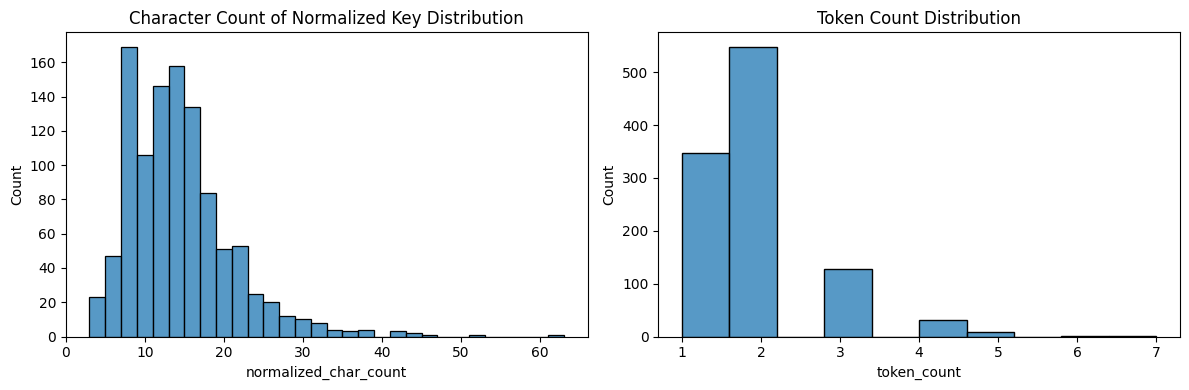

INFO: Histogram figure saved to /content/drive/MyDrive/Field-Key-Analysis/output/field_keys_character_and_token_hist.png


In [18]:

# Histograms
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(field_keys_df_eda["normalized_char_count"], bins=30, ax=ax[0])
ax[0].set_title("Character Count of Normalized Key Distribution")

sns.histplot(field_keys_df_eda["token_count"], bins=10, ax=ax[1])
ax[1].set_title("Token Count Distribution")

# Tight layout so titles/labels don’t overlap
fig.tight_layout()
plt.show()

# Save with dpi for better quality
out_path = OUT_DIR / "field_keys_character_and_token_hist.png"
fig.savefig(out_path, dpi=300)

logging.info("Histogram figure saved to %s", out_path)

# Optional: close to free memory if running many plots in a loop
plt.close(fig)

INFO: Pie chart saved to /content/drive/MyDrive/Field-Key-Analysis/output/unique_vs_duplicate_keys_pie_chart.png


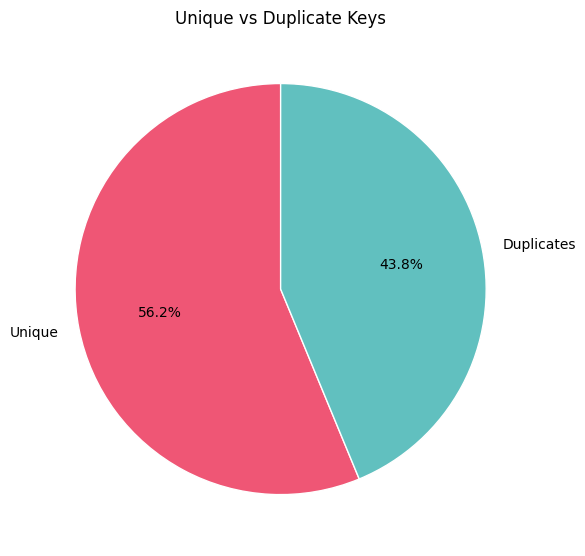

In [19]:
# Counts
total = field_keys_df_eda["normalized_field_key"].shape[0]
unique = field_keys_df_eda["normalized_field_key"].nunique()
duplicates = total - unique

# Data for pie chart
labels = ["Unique", "Duplicates"]
sizes = [unique, duplicates]
colors = ["#ef5675", "#61c0bf"]

# Plot pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white"},
)
ax.set_title("Unique vs Duplicate Keys")

# Tight layout
fig.tight_layout()

# Save with high resolution
out_path = OUT_DIR / "unique_vs_duplicate_keys_pie_chart.png"
fig.savefig(out_path, dpi=300)

logging.info("Pie chart saved to %s", out_path)

# Show for interactive use
plt.show()

# Close to free memory if running many plots
plt.close(fig)

## Token Validity Ratio

### Test Detection Functions

In [20]:
### Test is_camel_or_pascal case function
tests = [
    "patientName",  # camelCase → True
    "PatientName",  # PascalCase → True
    "fieldKeyID",  # camelCase → True
    "FieldKeyID",  # PascalCase → True
    "patient_firstName",  # snake_case → False
    "PATIENTNAME",  # all caps → False
    "patientname",  # all lower → False
    "patient-name",  # kebab-case → False
]


logging.info(
    "CamelCase tests:\n%s",
    "\n".join(f"\t{t:20} -> {is_camel_or_pascal(t)}" for t in tests),
)


### Test is_snake_case function
tests = [
    "nextappt_text",
    "patient_name",  # True
    "patient-first-name",  # True
    "field1-key2",  # True
    "Patient_Name",  # True (allowed, since we’re lax)
    "PATIENT-NAME",  # True
    "patientName",  # False (no _ or -)
    "patient name",  # False (space)
]

logging.info(
    "Snake_case tests:\n%s",
    "\n".join(f"\t{t:20} -> {is_snake_case_lax(t)}" for t in tests),
)


### Testing Valid Word Function
tests = [
    "interventions",  # valid
    "patient_first_name",  # valid
    "roleplay_txt",  # valid: roleplay, invalid: txt
    "abcxyz",  # invalid
]

res = {}
for e in tests:
    res[e] = key_word_validity(e, min_zipf=MIN_ZIPF, domain_words=DOMAIN_WORDS)

logging.info(
    "Valid Word tests:\n%s",
    "\n".join(
        f"\t{e:20} -> valid={res[e]['valid_tokens']} invalid={res[e]['invalid_tokens']}"
        for e in res
    ),
)

#### Test is_single_clean_word function
tests = [
    "Name",  # True (proper word)
    "name",  # True
    "followup",  # True
    "patientfirstname",  # False (glued, caught by is_glued_token)
    "PatientFirstName",  # False (camel)
    "patient_first_name",  # False (snake)
    "abcxyz",  # False (nonsense)
    "address",  # True
    "score1",  # False (digit)
    "psychoeducation",  # True (domain word, if in dict or freq ok)
]


logging.info(
    "Single clean word tests:\n%s",
    "\n".join(f"\t{t:20} -> {is_single_clean_word(t)}" for t in tests),
)

INFO: CamelCase tests:
	patientName          -> True
	PatientName          -> True
	fieldKeyID           -> True
	FieldKeyID           -> True
	patient_firstName    -> True
	PATIENTNAME          -> False
	patientname          -> False
	patient-name         -> False
INFO: Snake_case tests:
	nextappt_text        -> True
	patient_name         -> True
	patient-first-name   -> True
	field1-key2          -> True
	Patient_Name         -> True
	PATIENT-NAME         -> True
	patientName          -> False
	patient name         -> False
INFO: Valid Word tests:
	interventions        -> valid=['interventions'] invalid=[]
	patient_first_name   -> valid=['patient', 'first', 'name'] invalid=[]
	roleplay_txt         -> valid=[] invalid=['roleplay', 'txt']
	abcxyz               -> valid=[] invalid=['abcxyz']
INFO: Single clean word tests:
	Name                 -> True
	name                 -> False
	followup             -> True
	patientfirstname     -> False
	PatientFirstName     -> False
	patient_first

### Apply Functions

In [21]:
# Apply Validity Stats

field_keys_df["validity_stats"] = field_keys_df["field_key"].apply(
    lambda x: key_word_validity(x, min_zipf=MIN_ZIPF, domain_words=DOMAIN_WORDS)
)

# Expand dict results into columns
# 1) Ensure every row has a dict (or empty dict)""
stats_series = field_keys_df["validity_stats"].apply(
    lambda v: v if isinstance(v, dict) else {}
)

# 2) Expand into a DataFrame *with the same index*
validity_df = pd.DataFrame.from_records(stats_series, index=field_keys_df.index)

# 3) Join on index (no reindexing / no misalignment)
field_keys_df = field_keys_df.join(validity_df, how="left")

# thresholds: Invalid (<0.5), Partial (0.5–<0.8), Valid (>=0.8)
field_keys_df["token_validity_ratio_label"] = pd.cut(
    field_keys_df["token_valid_ratio"],
    bins=[-1, TOKEN_VALID_PAR_CUT, TOKEN_VALID_VALID_CUT, 1.01],
    labels=["INVALID", "PARTIAL", "VALID"],
)


logging.info("Field Keys DataFrame shape: %s", field_keys_df.shape)
field_keys_df.head()

INFO: Field Keys DataFrame shape: (1065, 16)


,field_key,field_title,field_type,field_key_exists_in_library_flag,row_id,organization_name,_merge,normalized_field_key,facet_title_missing,validity_stats,token_valid_ratio,char_valid_ratio,valid_tokens,invalid_tokens,tokens,token_validity_ratio_label
0,meeting_summary,סיכום הביקור,textarea,False,0,Amal,both,meeting summary,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",1.0,1.0,"[meeting, summary]",[],"[meeting, summary]",VALID
4,purpose,Purpose of Contact,textarea,False,9,Barry County CMHA,both,purpose,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",1.0,1.0,[purpose],[],[purpose],VALID
5,response,Client Response,textarea,False,10,Barry County CMHA,both,response,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",1.0,1.0,[response],[],[response],VALID
8,explanation,"Explanation (use direct quotes from Client, wh...",textarea,False,13,Barry County CMHA,both,explanation,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",1.0,1.0,[explanation],[],[explanation],VALID
11,observed_reported_mood_affect_behavior,Functioning - Observed or Reported (may includ...,textarea,False,16,Best Point,both,observed reported mood affect behavior,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",1.0,1.0,"[observed, reported, mood, affect, behavior]",[],"[observed, reported, mood, affect, behavior]",VALID


## Containment (Field Key - Field Title)

In [22]:
# Import necessary libraries
nlp = spacy.load("en_core_web_sm")

# Test overlap_scores function
res = overlap_scores(
    "Patient_FirstName", "Patient first name (legal)", synonyms=SYNONYMS
)
for k, v in res.items():
    logging.debug("%s: %s", k, v)

#### Apply Function

In [23]:
results = field_keys_df.apply(
    lambda row: overlap_scores(
        row["field_key"], row["field_title"], STOPWORDS, SYNONYMS
    ),
    axis=1,
)

# Convert series of dicts → dataframe
overlap_df = pd.DataFrame(list(results))
desired_metrics = overlap_df[
    ["containment_title", "matched_tokens", "key_tokens", "title_tokens"]
]

# Concatenate back to original df
field_keys_df = pd.concat(
    [(field_keys_df).reset_index(drop=True), desired_metrics], axis=1
)


# Apply categorization to each row in your DataFrame
labels_reasons = field_keys_df["containment_title"].apply(categorize_containment_title)

field_keys_df["containment_title_label"] = labels_reasons.map(lambda x: x[0])
field_keys_df["containment_title_label"] = field_keys_df[
    "containment_title_label"
].fillna("NONE")


field_keys_df["containment_title_reason"] = labels_reasons.map(lambda x: x[1])


logging.info(
    "Containment title label counts:\n%s",
    field_keys_df["containment_title_label"].value_counts(),
)


# --- Results ---
"""text_overlap_analysis = field_keys_df[[
    'field_key', 'field_title', 'containment_title', 'matched_tokens', 'key_tokens', 'title_tokens', 'containment_title_label',
    'field_type', 'field_key_exists_in_library_flag', 'facet_title_missing'
]]



text_overlap_analysis.to_csv('output/text_overlap_analysis.csv', index=False)
"""


field_keys_df.drop(columns=["containment_title_reason"], inplace=True)

logging.info("Field Keys DataFrame shape: %s", field_keys_df.shape)
field_keys_df.head()

INFO: Containment title label counts:
containment_title_label
LOW        608
HIGH       271
PARTIAL    186
Name: count, dtype: int64
INFO: Field Keys DataFrame shape: (1065, 21)


,field_key,field_title,field_type,field_key_exists_in_library_flag,row_id,organization_name,_merge,normalized_field_key,facet_title_missing,validity_stats,...,char_valid_ratio,valid_tokens,invalid_tokens,tokens,token_validity_ratio_label,containment_title,matched_tokens,key_tokens,title_tokens,containment_title_label
0,meeting_summary,סיכום הביקור,textarea,False,0,Amal,both,meeting summary,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,1.0,"[meeting, summary]",[],"[meeting, summary]",VALID,0.0000,[],"[summary, meeting]",[],LOW
1,purpose,Purpose of Contact,textarea,False,9,Barry County CMHA,both,purpose,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,1.0,[purpose],[],[purpose],VALID,0.5000,[purpose],[purpose],"[contact, purpose]",PARTIAL
2,response,Client Response,textarea,False,10,Barry County CMHA,both,response,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,1.0,[response],[],[response],VALID,0.5000,[response],[response],"[client, response]",PARTIAL
3,explanation,"Explanation (use direct quotes from Client, wh...",textarea,False,13,Barry County CMHA,both,explanation,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,1.0,[explanation],[],[explanation],VALID,0.1429,[explanation],[explanation],"[when, use, quote, direct, possible, explanati...",LOW
4,observed_reported_mood_affect_behavior,Functioning - Observed or Reported (may includ...,textarea,False,16,Best Point,both,observed reported mood affect behavior,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,1.0,"[observed, reported, mood, affect, behavior]",[],"[observed, reported, mood, affect, behavior]",VALID,0.4545,"[report, mood, affect, behavior, observe]","[report, mood, affect, behavior, observe]","[function, etc, may, report, functioning, mood...",LOW


## Cosine Similarity

### Prep text

In [24]:
# 1) Load a lightweight, strong general model
# Good default for short phrases; fast on CPU
EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
emb_model = SentenceTransformer(EMB_MODEL_NAME)


# 5) Apply to your DataFrame
field_keys_df["cosine_sim"] = compute_cosine_for_df(field_keys_df)

# Assign verdicts based on cosine similarity
field_keys_df["cosine_verdict"] = field_keys_df["cosine_sim"].apply(cosine_bucket)

# Results
logging.info(
    "Cosine verdict counts:\n%s", field_keys_df["cosine_verdict"].value_counts()
)


# cosine_similarity_analysis = field_keys_df[['field_key', 'field_title', 'containment_title', 'cosine_sim']]
# cosine_similarity_analysis.to_csv('output/cosine_similarity_analysis.csv', index=False)

INFO: Use pytorch device_name: cuda:0
INFO: Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

INFO: Cosine verdict counts:
cosine_verdict
MEDIUM    478
LOW       384
HIGH      203
Name: count, dtype: int64


### Save Cosine Results to Cache

In [25]:
# full path to pickle file
output_path = CACHE_DIR / "field_keys_df_cosine.pkl"

# write the DataFrame to pickle
with open(output_path, "wb") as f:
    pickle.dump(field_keys_df, f)
logging.info("Field Keys DataFrame saved to: %s", output_path)

INFO: Field Keys DataFrame saved to: /content/drive/MyDrive/Field-Key-Analysis/cache/field_keys_df_cosine.pkl


## Natural Language Inference (NLI)

### Test NLI_functions

In [26]:
# Load the DataFrame from pickle
output_path = CACHE_DIR / "field_keys_df_cosine.pkl"
with open(output_path, "rb") as f:
    field_keys_df = pickle.load(f)

logging.info("Field Keys DataFrame loaded from: %s", output_path)


# test_nli.py (optional snippet to run in your notebook)

pairs = [
    ("progress", "Client progress since last session"),
    ("Purpose", "Purpose of Contact"),
    ("Diagnosis", "Client strengths"),
    ("treatment_plan", "Treatment Plan"),
    ("Provider_response", "Client response"),
]

df = nli_probe_report(pairs)
print(df)

INFO: Field Keys DataFrame loaded from: /content/drive/MyDrive/Field-Key-Analysis/cache/field_keys_df_cosine.pkl
                 key                               title      t2k_label  \
0           progress  Client progress since last session     entailment   
1            Purpose                  Purpose of Contact     entailment   
2          Diagnosis                    Client strengths  contradiction   
3     treatment_plan                      Treatment Plan     entailment   
4  Provider_response                     Client response  contradiction   

   t2k_conf      k2t_label  k2t_conf  
0  0.870750        neutral  0.991540  
1  0.783634        neutral  0.971568  
2  0.566884  contradiction  0.846645  
3  0.903289     entailment  0.898910  
4  0.951309  contradiction  0.940561  


### Apply Functions to Dataframe

In [27]:
field_keys_df = add_axis_columns_batched(field_keys_df, compute_k2t=False)
field_keys_df["nli_axis_label"] = field_keys_df["nli_axis_label"].fillna(LBL_UNCERTAIN)

# Peek
field_keys_df[["field_key", "field_title", "nli_axis", "nli_axis_label"]].head()


# Results
"""
nli_analysis = field_keys_df[['field_key','field_title', 'nli_axis', 'nli_axis_label']]
nli_analysis.to_csv('output/nli_analysis.csv', index=False)
"""

logging.info("Field Keys DataFrame shape: %s", field_keys_df.shape)
logging.info(
    "NLI axis label counts:\n%s", field_keys_df["nli_axis_label"].value_counts()
)
field_keys_df.head()

INFO: Field Keys DataFrame shape: (1065, 25)
INFO: NLI axis label counts:
nli_axis_label
Weak Match               398
Uncertain                374
Exact Match              217
Partial Contradiction     55
Strong Contradiction      21
Name: count, dtype: int64


,field_key,field_title,field_type,field_key_exists_in_library_flag,row_id,organization_name,_merge,normalized_field_key,facet_title_missing,validity_stats,...,token_validity_ratio_label,containment_title,matched_tokens,key_tokens,title_tokens,containment_title_label,cosine_sim,cosine_verdict,nli_axis,nli_axis_label
0,meeting_summary,סיכום הביקור,textarea,False,0,Amal,both,meeting summary,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,VALID,0.0000,[],"[summary, meeting]",[],LOW,0.231242,LOW,-0.222508,Partial Contradiction
1,purpose,Purpose of Contact,textarea,False,9,Barry County CMHA,both,purpose,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,VALID,0.5000,[purpose],[purpose],"[contact, purpose]",PARTIAL,0.605536,MEDIUM,0.340272,Weak Match
2,response,Client Response,textarea,False,10,Barry County CMHA,both,response,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,VALID,0.5000,[response],[response],"[client, response]",PARTIAL,0.564328,MEDIUM,0.475051,Weak Match
3,explanation,"Explanation (use direct quotes from Client, wh...",textarea,False,13,Barry County CMHA,both,explanation,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,VALID,0.1429,[explanation],[explanation],"[when, use, quote, direct, possible, explanati...",LOW,0.131485,LOW,0.434662,Weak Match
4,observed_reported_mood_affect_behavior,Functioning - Observed or Reported (may includ...,textarea,False,16,Best Point,both,observed reported mood affect behavior,False,"{'token_valid_ratio': 1.0, 'char_valid_ratio':...",...,VALID,0.4545,"[report, mood, affect, behavior, observe]","[report, mood, affect, behavior, observe]","[function, etc, may, report, functioning, mood...",LOW,0.817665,MEDIUM,0.789676,Exact Match


### Save NLI Results to Cache

In [28]:
# full path to pickle file
output_path = CACHE_DIR / "field_keys_df_with_nli.pkl"

# write the DataFrame to pickle
with open(output_path, "wb") as f:
    pickle.dump(field_keys_df, f)

logging.info("Field Keys DataFrame saved to: %s", output_path)

INFO: Field Keys DataFrame saved to: /content/drive/MyDrive/Field-Key-Analysis/cache/field_keys_df_with_nli.pkl


## Facet Detectors

In [29]:
# Load nli_results dataframe
output_path = os.path.join(CACHE_DIR, "field_keys_df_with_nli.pkl")
with open(output_path, "rb") as f:
    field_keys_df = pickle.load(f)
logging.info("Field Keys DataFrame loaded from: %s", output_path)

INFO: Field Keys DataFrame loaded from: /content/drive/MyDrive/Field-Key-Analysis/cache/field_keys_df_with_nli.pkl


In [30]:
## Creating len_ratio components
field_keys_df["key_tokens_count"] = field_keys_df["key_tokens"].apply(count_tokens)
field_keys_df["title_tokens_count"] = field_keys_df["title_tokens"].apply(count_tokens)

# len_ratio = title_tokens_count / key_tokens_count
denom = field_keys_df["key_tokens_count"].replace(0, 1)  # avoid divide-by-zero
field_keys_df["len_ratio"] = (
    (field_keys_df["title_tokens_count"] / denom)
    .astype(float)
    .clip(upper=LEN_RATIO_THRESHOLD)
)

field_keys_df[
    [
        "field_key",
        "field_title",
        "key_tokens",
        "key_tokens_count",
        "title_tokens",
        "title_tokens_count",
        "len_ratio",
    ]
].sort_values(by="len_ratio", ascending=False).head(10)
field_keys_df.drop(columns=["key_tokens_count", "title_tokens_count"], inplace=True)

### Create Facets

In [31]:
# ---- Facets (booleans) ---------------------------------------------------
# 1) Different Concepts (hard mismatch)
field_keys_df["facet_hard_mismatch"] = (
    field_keys_df["nli_axis"] <= STRONG_CONTRA_CUT
) | (
    (field_keys_df["containment_title_label"] == LOW_CONTAINMENT_LABEL)
    & (field_keys_df["cosine_sim"] < COSINE_MEDIUM_CUT)
)


# 2) Partial Mismatch (semantic tension)
field_keys_df["facet_partial_mismatch"] = (
    (
        (field_keys_df["nli_axis"] > STRONG_CONTRA_CUT)
        & (field_keys_df["nli_axis"] <= PARTIAL_CONTRA_CUT)
    )
    | (
        (field_keys_df["containment_title_label"] == PARTIAL_CONTAINMENT_LABEL)
        & (field_keys_df["cosine_sim"] < COSINE_MEDIUM_CUT)
    )
    | (
        (field_keys_df["containment_title_label"] == LOW_CONTAINMENT_LABEL)
        & (
            (field_keys_df["cosine_sim"] < COSINE_HIGH_CUT)
            & (field_keys_df["cosine_sim"] > COSINE_MEDIUM_CUT)
        )
    )
    & ~field_keys_df["facet_hard_mismatch"]
)


# 3) Missing Context (key too generic vs title)
field_keys_df["facet_missing_context"] = (
    (field_keys_df["len_ratio"] >= LEN_RATIO_THRESHOLD)
    & (field_keys_df["matched_tokens"].apply(count_tokens) >= MIN_MATCHED_TOKENS)
    & (field_keys_df["nli_axis_label"].isin([LBL_UNCERTAIN, LBL_WEAK]))
    & ~(field_keys_df["facet_hard_mismatch"] | field_keys_df["facet_partial_mismatch"])
)

# ---4) Hidden Agent and Temporal Mismatch  ---
# normalize token columns to lists of lowercase strings
key_toks = field_keys_df["key_tokens"].apply(_tokens_from_cell)
title_toks = field_keys_df["title_tokens"].apply(_tokens_from_cell)

# compute lexicon hits
field_keys_df["key_actor_hits"] = key_toks.apply(
    lambda ts: _count_lex_hits(ts, ACTOR_LEX)
)
field_keys_df["title_actor_hits"] = title_toks.apply(
    lambda ts: _count_lex_hits(ts, ACTOR_LEX)
)

field_keys_df["key_temporal_hit"] = key_toks.apply(
    lambda ts: _has_lexicon_hit(ts, TEMPORAL_LEX)
)
field_keys_df["title_temporal_hit"] = title_toks.apply(
    lambda ts: _has_lexicon_hit(ts, TEMPORAL_LEX)
)

# gate: NLI not strongly negative AND title present
# (your condition: nli_axis >= -0.15 and not facet_title_missing)
gate = (field_keys_df["nli_axis"].astype(float) >= -0.15) & (
    ~field_keys_df["facet_title_missing"].astype(bool)
)

# facets
field_keys_df["facet_hidden_agent"] = gate & (
    field_keys_df["title_actor_hits"] > field_keys_df["key_actor_hits"]
)
field_keys_df["facet_temporal_mismatch"] = gate & (
    field_keys_df["title_temporal_hit"] & ~field_keys_df["key_temporal_hit"]
)


# 5) Token Validity Issues
field_keys_df["facet_token_validity_issues"] = (
    field_keys_df["token_valid_ratio"] < 1
) | (field_keys_df["invalid_tokens"].apply(count_tokens) >= 1)

### Create Severity Scores

In [32]:
# Apply to DataFrame

field_keys_df["semantic_severity"] = field_keys_df.apply(semantic_severity, axis=1)
logging.info(
    "Semantic severity range: min=%.4f, max=%.4f",
    field_keys_df["semantic_severity"].min(),
    field_keys_df["semantic_severity"].max(),
)


MISSING_TITLE_PENALTY = 0.3

structural = field_keys_df["token_valid_ratio"].astype(float).clip(0, 1)
structural = np.where(
    field_keys_df["facet_title_missing"].fillna(False).astype(bool),
    np.maximum(0.0, structural - MISSING_TITLE_PENALTY),
    structural,
)


field_keys_df["structural_severity"] = structural


field_keys_df["final_severity"] = (
    0.3 * field_keys_df["semantic_severity"].astype(float)
    + 0.7 * field_keys_df["structural_severity"].astype(float)
).clip(0.0, 1.0)

INFO: Semantic severity range: min=0.2438, max=0.9777


### Create Reasons column

In [33]:
# Identify facet columns automatically (those starting with "facet_")
facet_cols = [c for c in field_keys_df.columns if c.startswith("facet_")]


# Create a new 'reasons' column while leaving facet columns untouched
field_keys_df["reasons"] = field_keys_df.apply(collect_facets, axis=1)


# facet_cols was created earlier, e.g.:
# facet_cols = [c for c in field_keys_df.columns if c.startswith("facet_")]

cols_to_drop = [
    "key_temporal_hit",
    "title_temporal_hit",
    "key_actor_hits",
    "title_actor_hits",
]

field_keys_df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

### Merge back with original data frame

In [34]:
# Merge with the original field_keys DataFrame
merged = field_keys.merge(
    field_keys_df,
    on="row_id",
    how="left",
    suffixes= ("", "_dup")
)

merged = merged.drop(columns=[c for c in merged.columns if c.endswith("_dup")])


new_order = ['report_class_id', 'organization_name','field_key','field_title', 'field_type','field_key_definition', 'row_id',
 'field_key_exists_in_library_flag', 'structural_severity', 'semantic_severity', 'final_severity','reasons',
 'normalized_field_key', 'validity_stats', 'token_valid_ratio', 'char_valid_ratio', 'valid_tokens', 'invalid_tokens',
 'tokens', 'token_validity_ratio_label', 'containment_title', 'matched_tokens','key_tokens', 'title_tokens','containment_title_label',
 'cosine_sim', 'cosine_verdict', 'nli_axis', 'nli_axis_label', 'len_ratio', 'facet_title_missing','facet_hard_mismatch',
 'facet_partial_mismatch', 'facet_missing_context', 'facet_hidden_agent', 'facet_temporal_mismatch','facet_token_validity_issues']

merged = merged[new_order]

logging.info("Field Keys DataFrame shape: %s", field_keys.shape)
logging.info("Merged DataFrame shape: %s", merged.shape)



merged.to_csv("output/final_df.csv", index=False)
merged.head()

INFO: Field Keys DataFrame shape: (2289, 9)
INFO: Merged DataFrame shape: (2289, 37)


,report_class_id,organization_name,field_key,field_title,field_type,field_key_definition,row_id,field_key_exists_in_library_flag,structural_severity,semantic_severity,...,nli_axis,nli_axis_label,len_ratio,facet_title_missing,facet_hard_mismatch,facet_partial_mismatch,facet_missing_context,facet_hidden_agent,facet_temporal_mismatch,facet_token_validity_issues
0,AmalReport,Amal,meeting_summary,סיכום הביקור,textarea,NaN,0,False,1.0,0.302620,...,-0.222508,Partial Contradiction,0.0,False,True,True,False,False,False,False
1,APNFamilyTherapyReport,Hillsides,data,Data:,textarea,The Field ‘data' contains the main topics cove...,1,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,APNFamilyTherapyReport,Hillsides,assessment,Assessment:,textarea,This field captures the thorough analysis or e...,2,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,APNFamilyTherapyReport,Hillsides,plan,Plan:,textarea,This field describes the future steps or actio...,3,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BarryCountyCMHAPeerSupportNoteReport,Barry County CMHA,purpose,Purpose of Contact,textarea,NaN,9,False,1.0,0.633742,...,0.340272,Weak Match,1.5,False,False,False,True,False,False,False


## Summary (key metrics + artifact paths)



In [35]:
artifacts = [
    OUT_DIR / "final_df.csv",
    OUT_DIR / "field_keys_character_and_token_hist.png",
    OUT_DIR / "unique_vs_duplicate_keys_pie_chart.png",
]

manifest_lines = []
for p in artifacts:
    status = "OK" if Path(p).exists() else "MISSING"
    manifest_lines.append(f"- {p}  [{status}]")

logging.info("Artifact manifest:\n%s", "\n".join(manifest_lines))

INFO: Artifact manifest:
- /content/drive/MyDrive/Field-Key-Analysis/output/final_df.csv  [OK]
- /content/drive/MyDrive/Field-Key-Analysis/output/field_keys_character_and_token_hist.png  [OK]
- /content/drive/MyDrive/Field-Key-Analysis/output/unique_vs_duplicate_keys_pie_chart.png  [OK]
